In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_PATH =  '../../../data/cluster/year/'
#os.listdir(DATA_PATH)

In [3]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = util.load_data(DATA_PATH)

X_train: (529623, 24)
X_valid: (176541, 24)
X_test: (176541, 24)
y_train: (529623, 1)
y_valid: (176541, 1)
y_test: (176541, 1)


In [4]:
# See sdm/R/models/logisticModEDA.R.ipynb for details
def transform(field, field_name, transform_map):
    field_min = field.min()
    field = (field + np.abs(field_min) + 1) ** transform_map[field_name]
    return field

In [5]:
def transform_data_set(dataframe):
    data = dataframe.copy()
    transform_map = {
        'meanTemp_Annual': 0.4897778,
        'meanTemp_AprAug': 0.3060202,
        'meanTemp_Aug': 0.137697,
        'meanMinTemp_DecFeb': 0.9713939,
        'meanMinTemp_Oct': -0.1194343,
        'meanMinTemp_Jan': 1.064485,
        'meanMinTemp_Mar': 1.355394,
        'meanMaxTemp_Aug': 0.5649293,
        'precip_meanAnnual': 0.05793939,
        'precip_JunAug': 0.6671515,
        'precipPrevious_JunAug': 0.6300606,
        'precip_OctSep': 0.004686869,
        'precipPrevious_OctSep': 0.06690909,
        'precip_growingSeason': 0.4829899,
        'varPrecip_growingSeason': 0.349899,
        'elev_etopo1': 0.4753939}
    for field in transform_map:
        data[field] = transform(data[field], field, transform_map)
    return data

In [6]:
def make_squared(dataframe, fields):
    df = dataframe.copy()
    for field in fields:
        df['%s_sq' % field] = df[field] ** 2
    return df

In [7]:
def make_interactions(dataframe, interactions):
    df = dataframe.copy()
    for interaction in interactions:
        main_effects = interaction.split(':')
        df[interaction] = df[main_effects[0]] * df[main_effects[1]]
    return df

In [8]:
sq_fields = [
    'meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug',
    'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan',
    'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual',
    'precip_JunAug', 'precipPrevious_JunAug', 'precip_OctSep',
    'precipPrevious_OctSep', 'precip_growingSeason',
    'elev_etopo1', 'lat', 'lon']
interactions = [
    'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep',
    'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct',
    'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual',
    'precip_OctSep:meanTemp_Aug', 'precip_OctSep:meanMinTemp_Oct',
    'precip_OctSep:elev_etopo1', 'precip_OctSep:elev_etopo1',
    'precip_OctSep:lat', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:precipPrevious_OctSep',
    'precip_OctSep:precip_meanAnnual', 'precip_OctSep:precip_OctSep',
    'meanMaxTemp_Aug:precip_OctSep', 'meanTemp_AprAug:precip_OctSep',
    'precip_OctSep:varPrecip_growingSeason', 'meanTemp_Aug:precip_OctSep']

In [9]:
#X_train = transform_data_set(X_train)
#X_valid = transform_data_set(X_valid)
#X_test  = transform_data_set(X_test)

In [10]:
X_train = make_squared(X_train, sq_fields)
X_valid = make_squared(X_valid, sq_fields)
X_test  = make_squared(X_test, sq_fields)

In [11]:
X_train = make_interactions(X_train, interactions)
X_valid = make_interactions(X_valid, interactions)
X_test  = make_interactions(X_test, interactions)

In [12]:
#list(X_train)

In [13]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.26%
Percent presence in y_valid: 13.92%
Percent presence in y_test: 12.64%


In [14]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [15]:
#np.isfinite(X_valid).all()

In [16]:
#X_train, y_train = util.drop_nans(
#    X_train, y_train, 'varPrecip_growingSeason')
#X_valid, y_valid = util.drop_nans(
#    X_valid, y_valid, 'varPrecip_growingSeason')
#X_test,  y_test  = util.drop_nans(
#    X_test,  y_test,  'varPrecip_growingSeason')

#X_train, y_train = util.drop_nans(
#    X_train, y_train, 'precip_OctSep:varPrecip_growingSeason')
#X_valid, y_valid = util.drop_nans(
#    X_valid, y_valid, 'precip_OctSep:varPrecip_growingSeason')
#X_test,  y_test  = util.drop_nans(
#    X_test,  y_test,  'precip_OctSep:varPrecip_growingSeason')

In [17]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [18]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)
X_valid = X_valid.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)
X_test  = X_test.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)

In [19]:
predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'meanTemp_Annual_sq', 'meanTemp_AprAug_sq', 'meanTemp_Aug_sq', 'meanMinTemp_DecFeb_sq', 'meanMinTemp_Oct_sq', 'meanMinTemp_Jan_sq', 'meanMinTemp_Mar_sq', 'meanMaxTemp_Aug_sq', 'precip_meanAnnual_sq', 'precip_JunAug_sq', 'precipPrevious_JunAug_sq', 'precip_OctSep_sq', 'precipPrevious_OctSep_sq', 'precip_growingSeason_sq', 'elev_etopo1_sq', 'lat_sq', 'lon_sq', 'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep', 'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct', 'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason', 'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual', 'precip_OctSep:meanTemp_Aug', 'precip_OctSep:m

In [20]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [21]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [ ]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = np.logspace(-4, 0, 5)

t0 = time.time()
for C in Cs:
    print('Testing C =', C)
    for penalty in ['l1', 'l2']:
        print('  %s:' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_train, y_train)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        print(accuracy)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        #print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.0001
  l1: 0.865147472825
  l2: 0.887306631321
Testing C = 0.001
  l1: 0.892886071791
  l2: 0.893820698874
Testing C = 0.01
  l1: 0.890648631196
  l2: 0.890620309163
Testing C = 0.1
  l1: 

In [ ]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [22]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = np.logspace(-3.5, -2.5, 5)

t0 = time.time()
for C in Cs:
    print('Testing C =', C)
    for penalty in ['l1', 'l2']:
        print('  %s:' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_train, y_train)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        print(accuracy)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        #print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.000316227766017
  l1: 0.887148027937
  l2: 0.892812434505
Testing C = 0.00056234132519
  l1: 0.891441648116
  l2: 0.893429854821
Testing C = 0.001
  l1: 0.892874742978
  l2: 0.893820698874
Testing C = 0.00177827941004
  l1: 0.893044675175
  l2: 0.893520485326
Testing C = 0.00316227766017
  l1: 0.892472570111
  l2: 0.893254258218


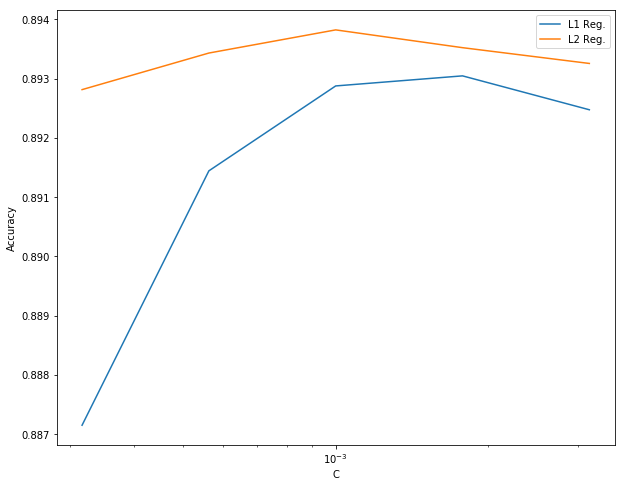

In [23]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [22]:
logistic_clf = LogisticRegression(C=0.001, penalty='l2')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.88458205176134719

In [23]:
def get_predictions_at_threshold(pred_ps, threshold):
    return 1 * (pred_ps >= threshold)

def threshold_plot(pred_ps, targets):
    thresholds = np.linspace(0, 1, 500)
    accuracies = []
    n = len(pred_ps)

    for threshold in thresholds:
        preds = get_predictions_at_threshold(pred_ps, threshold)
        accuracies.append((preds == targets).sum() / n)
        
    plt.plot(thresholds, accuracies);
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_accuracy = max(accuracies)
    plt.plot([optimal_threshold, optimal_threshold], 
             [min(accuracies), max(accuracies)], 
             'r')
    plt.plot([0, 1], [optimal_accuracy, optimal_accuracy], 'r')
    plt.xlabel('Threshold for predicting "Renewal"')
    plt.ylabel('Accuracy')
    plt.show()
    return {'threshold': optimal_threshold, 'accuracy': optimal_accuracy}

[[  9.99298994e-01   7.01005806e-04]
 [  9.99385156e-01   6.14844005e-04]
 [  9.99500304e-01   4.99695979e-04]
 [  9.98990712e-01   1.00928773e-03]
 [  9.99125519e-01   8.74480872e-04]]


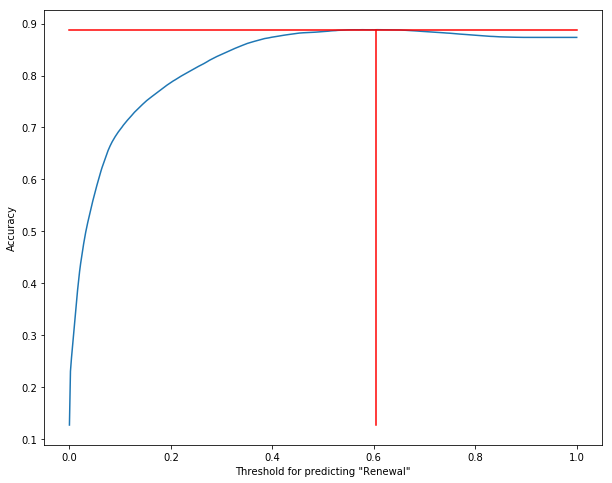

{'threshold': 0.60521042084168331, 'accuracy': 0.8884621702607326}


In [24]:
pred_ps = logistic_clf.predict_proba(X_test)
print(pred_ps[:5])
pred_ps = np.array([p[1] for p in pred_ps])
pred_ps[:5]

THRESHOLD = 0.5
preds = get_predictions_at_threshold(pred_ps, THRESHOLD)
preds[:5]

best_threshold = threshold_plot(pred_ps, y_test);
print(best_threshold)

In [25]:
preds = logistic_clf.predict(X_test)

In [26]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.5)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	13090		9225
        0	11151		143075
Accuracy:  0.884582051761
Precision: 0.539994224661
Recall:    0.586600941071
F1:        0.562333533809


In [27]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.60521042084168331)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	9183		13132
        0	6559		147667
Accuracy:  0.888462170261
Precision: 0.583343920722
Recall:    0.411516916872
F1:        0.482591901621


In [28]:
auc_metrics = util.get_auc(y_test, pred_ps)

AUC:       0.918877659712


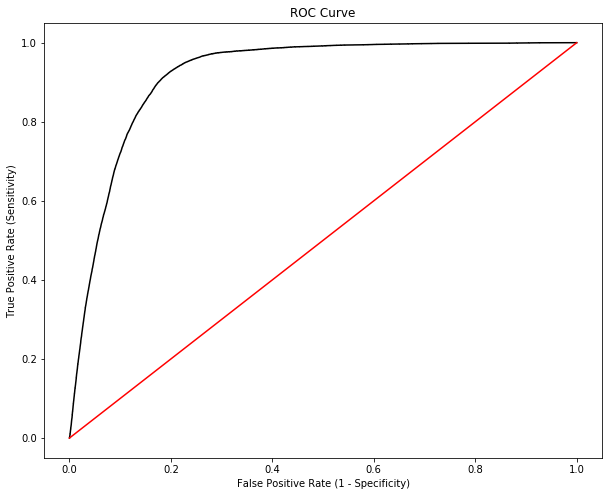

In [29]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [30]:
coefs = pd.DataFrame(
    [[pred, coef] 
     for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
    columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
10,vegetation,1.184105
18,meanTemp_Annual_sq,-0.783037
16,lat,0.753304
20,meanTemp_Aug_sq,-0.705896
9,precip_JunAug,-0.685679
19,meanTemp_AprAug_sq,-0.592755
21,meanMinTemp_DecFeb_sq,-0.532453
23,meanMinTemp_Jan_sq,-0.528310
39,precip_OctSep:lon,0.507067
7,meanMaxTemp_Aug,0.470431


In [34]:
full_test['probs'] = pred_ps
full_test['preds'] = get_predictions_at_threshold(pred_ps, 
                                                  0.60521042084168331)
full_test.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,precip_OctSep:lat,precip_OctSep:precip_meanAnnual,precip_OctSep:precip_OctSep,meanMaxTemp_Aug:precip_OctSep,meanTemp_AprAug:precip_OctSep,precip_OctSep:varPrecip_growingSeason,meanTemp_Aug:precip_OctSep,beetle,preds,probs
0,2000,17.057845,18.892138,21.608865,4.831345,10.825336,6.119776,7.627907,27.147665,7.199924,...,3942.380630,930.493385,16702.086497,3508.470629,2441.554720,87.162470,2792.655201,0,0,0.000701
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,3385.157228,734.347107,12299.783937,3032.901079,2119.301565,87.706257,2418.688598,0,0,0.000615
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,3175.790555,676.543063,10812.676193,2973.615041,2053.322479,180.105604,2350.966874,0,0,0.000500
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,6033.479765,1962.119381,38981.490270,5676.177043,3724.608934,33.989244,4365.768436,0,0,0.001009
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,5961.906526,1937.963301,38018.045803,5813.019043,3768.656495,71.096740,4432.299443,0,0,0.000874


In [35]:
def pred_plot(actual_matrix, pred_matrix, error_matrix, year):
    plt.subplot(131)
    imshow(np.rot90(actual_matrix));
    plt.title('%d Actual' % year);
    plt.subplot(132)
    imshow(np.rot90(pred_matrix));
    plt.title('%d Predicted' % year);
    plt.subplot(133)
    imshow(np.rot90(error_matrix));
    plt.title('%d Error' % year);

In [36]:
def make_actual_pred_and_error_matrices(data, year, plot=False):
    data_year = data.loc[data.year == year, :]
    actual_matrix = util.column2matrix(data_year, 'beetle')
    pred_matrix   = util.column2matrix(data_year, 'preds')
    error_matrix  = pred_matrix - actual_matrix
    
    if plot:
        pred_plot(actual_matrix, pred_matrix, error_matrix, year)
        
    return actual_matrix, pred_matrix, error_matrix

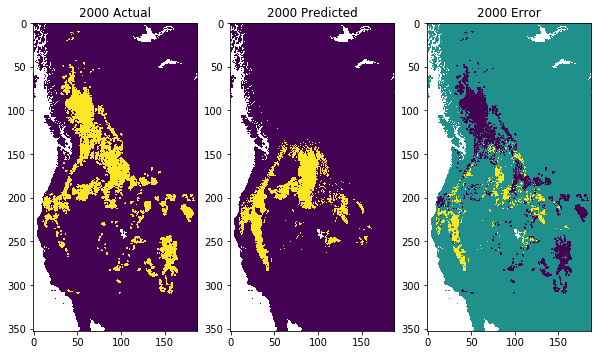

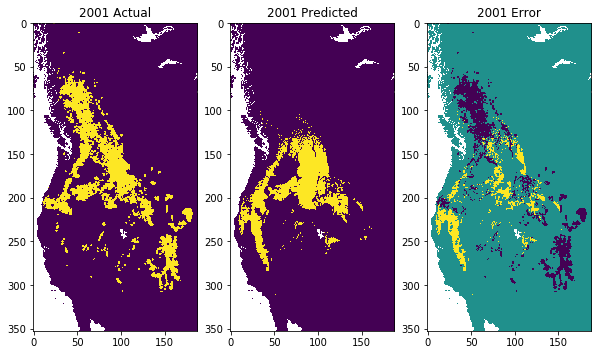

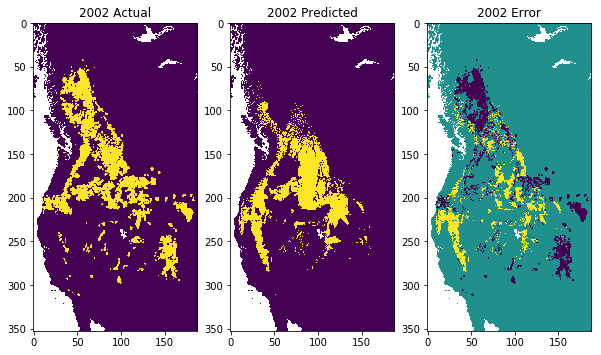

In [37]:
pred_years = [2000, 2001, 2002]
for year in pred_years:
    plt.figure();
    make_actual_pred_and_error_matrices(full_test, year, plot=True)

Using squared and interaction terms:
```
Acc: 0.884587716168
Adj: 0.888416855008
```

Using norm-transformations and interaction terms
```
worse
```


Using raw and interaction terms
```
worse
```


Using raw only
```
Acc: 0.87328156065729778
Adj: 0.888416855008
```